In [15]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from math import sqrt
import matplotlib.pyplot as plt
import gc

In [16]:
image_size = 80
num_labels = 37
num_channels = 1 # grayscale

def reformat(dataset):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  return dataset

def accuracy(predictions, labels):
    return np.sqrt(((predictions - labels) ** 2).mean())


In [17]:
pickle_file = 'galaxies.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = (save['train_dataset'])[0:1]
  train_labels = (save['train_labels'])[0:1]
  valid_dataset = (save['valid_dataset'])
  valid_labels = (save['valid_labels'])
  test_dataset = (save['test_dataset'])
  test_labels = (save['test_labels'])

  del save  # hint to help gc free up memory
    
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (1, 80, 80) (1, 37)
Validation set (20000, 80, 80) (20000, 37)
Test set (20000, 80, 80) (20000, 37)


In [18]:

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (1, 80, 80, 1) (1, 37)
Validation set (20000, 80, 80, 1) (20000, 37)
Test set (20000, 80, 80, 1) (20000, 37)


In [19]:
gc.collect()

103719

In [6]:
#   MODEL 5
batch_size = 128 #109
patch_size = 5
depth = 32 #32, 16
num_hidden = 64 #100
num_hidden2 = 64 #37
beta = 0.0002#0.0002
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=sqrt(2.0/(image_size // 4 * image_size // 4 * depth * num_hidden))))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  print(str(num_hidden))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=sqrt(2.0/(num_hidden * num_hidden2))))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  print(str(num_hidden2))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=sqrt(2.0/(num_hidden2 * num_labels))))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer2_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(hidden2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss1 = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(logits, tf_train_labels))))
  loss = loss1 + beta * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights))
    
 # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(0.3, global_step, 5000 ,0.96, staircase = True) #5000
  learning_rate = tf.Variable(0.3)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
   

  # Predictions for the training, validation, and test data.
  def prediction(logits):
    pred1 = tf.nn.softmax(logits[:,0:3])
    pred2 = tf.nn.relu(logits[:,3:num_labels])
    pred = tf.concat([pred1, pred2],1)
    return pred
  train_prediction1 = prediction(logits)
   #drop out some of the predictions
  train_prediction = tf.nn.dropout(train_prediction1,0.5)
  

  valid_prediction =prediction(model(valid_dataset))
  test_prediction = prediction(model(test_dataset))

  tf.add_to_collection('vars',  layer1_weights)
  tf.add_to_collection('vars',  layer2_weights)
  tf.add_to_collection('vars',  layer3_weights)
  tf.add_to_collection('vars',  layer4_weights)
  tf.add_to_collection('vars',  layer5_weights)
  tf.add_to_collection('vars',  layer1_biases)
  tf.add_to_collection('vars',  layer2_biases)
  tf.add_to_collection('vars',  layer3_biases)
  tf.add_to_collection('vars',  layer4_biases)
  tf.add_to_collection('vars',  layer5_biases)
  saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

64
64


In [7]:
gc.collect()
acc = 0
t = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model5.ckpt')
    print("Model restored.") 
    print('Initialized')
    for i in range(0,20): 
        a = accuracy((prediction(model(valid_dataset[i*1000:(i+1)*1000]))).eval(), valid_labels[i*1000:(i+1)*1000])
        acc = acc + a
        t.append(a)
    plt.plot(range(0,20), t, 'r')
    plt.axis([0, 20, 0, 0.2])
    acc = acc / 20
    print('Test accuracy: %f' % acc)

Model restored.
Initialized
Test accuracy: 0.112352


In [8]:
# MODEL 6
batch_size = 128 #109
patch_size = 5
depth = 32 #32, 16
num_hidden = 100
num_hidden2 = 37
beta = 0.0002#0.0002
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=sqrt(2.0/(image_size // 4 * image_size // 4 * depth * num_hidden))))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  print(str(num_hidden))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=sqrt(2.0/(num_hidden * num_hidden2))))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  print(str(num_hidden2))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=sqrt(2.0/(num_hidden2 * num_labels))))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer2_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(hidden2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss1 = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(logits, tf_train_labels))))
  loss = loss1 + beta * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights))
    
 # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(0.3, global_step, 5000 ,0.96, staircase = True) #5000
  learning_rate = tf.Variable(0.3)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
   

  # Predictions for the training, validation, and test data.
  def prediction(logits):
    pred1 = tf.nn.softmax(logits[:,0:3])
    pred2 = tf.nn.relu(logits[:,3:num_labels])
    pred = tf.concat([pred1, pred2],1)
    return pred
  train_prediction1 = prediction(logits)
    
   #drop out some of the predictions
  train_prediction = tf.nn.dropout(train_prediction1,0.5)
  

  valid_prediction =prediction(model(valid_dataset))
  test_prediction = prediction(model(test_dataset))

  tf.add_to_collection('vars',  layer1_weights)
  tf.add_to_collection('vars',  layer2_weights)
  tf.add_to_collection('vars',  layer3_weights)
  tf.add_to_collection('vars',  layer4_weights)
  tf.add_to_collection('vars',  layer5_weights)
  tf.add_to_collection('vars',  layer1_biases)
  tf.add_to_collection('vars',  layer2_biases)
  tf.add_to_collection('vars',  layer3_biases)
  tf.add_to_collection('vars',  layer4_biases)
  tf.add_to_collection('vars',  layer5_biases)
  saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

100
37


In [20]:
gc.collect()
acc = 0
t = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model6.ckpt')
    print("Model restored.") 
    print('Initialized')
    for i in range(0,20): 
        a = accuracy((prediction(model(test_dataset[i*1000:(i+1)*1000]))).eval(), test_labels[i*1000:(i+1)*1000])
        acc = acc + a
        t.append(a)
    plt.plot(range(0,20), t, 'b')
    plt.axis([0, 20, 0, 0.2])
    acc = acc / 20
    print('Test accuracy: %f' % acc)

Model restored.
Initialized
Test accuracy: 0.123348


In [10]:
#   MODEL 7
batch_size = 109
patch_size = 5
depth = 32 #32, 16
num_hidden = 100
num_hidden2 = 37
beta = 0.0002#0.0002
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=sqrt(2.0/(image_size // 4 * image_size // 4 * depth * num_hidden))))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  print(str(num_hidden))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=sqrt(2.0/(num_hidden * num_hidden2))))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  print(str(num_hidden2))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=sqrt(2.0/(num_hidden2 * num_labels))))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer2_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(hidden2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss1 = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(logits, tf_train_labels))))
  loss = loss1 + beta * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights))
    
 # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(0.3, global_step, 5000 ,0.96, staircase = True) #5000
  learning_rate = tf.Variable(0.3)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
   

  # Predictions for the training, validation, and test data.
  def prediction(logits):
    pred1 = tf.nn.softmax(logits[:,0:3])
    pred2 = tf.nn.relu(logits[:,3:num_labels])
    pred = tf.concat([pred1, pred2],1)
    return pred
  train_prediction1 = prediction(logits)
   #drop out some of the predictions
  train_prediction = tf.nn.dropout(train_prediction1,0.5)
  

  valid_prediction =prediction(model(valid_dataset))
  test_prediction = prediction(model(test_dataset))

  tf.add_to_collection('vars',  layer1_weights)
  tf.add_to_collection('vars',  layer2_weights)
  tf.add_to_collection('vars',  layer3_weights)
  tf.add_to_collection('vars',  layer4_weights)
  tf.add_to_collection('vars',  layer5_weights)
  tf.add_to_collection('vars',  layer1_biases)
  tf.add_to_collection('vars',  layer2_biases)
  tf.add_to_collection('vars',  layer3_biases)
  tf.add_to_collection('vars',  layer4_biases)
  tf.add_to_collection('vars',  layer5_biases)
  saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

100
37


In [11]:
gc.collect()
acc = 0
t = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model4.ckpt')
    print("Model restored.") 
    print('Initialized')
    for i in range(0,20): 
        a = accuracy((prediction(model(test_dataset[i*1000:(i+1)*1000]))).eval(), test_labels[i*1000:(i+1)*1000])
        acc = acc + a
        t.append(a)
    plt.plot(range(0,20), t, 'g')
    plt.axis([0, 20, 0, 0.2])
    acc = acc / 20
    print('Test accuracy: %f' % acc)

Model restored.
Initialized
Test accuracy: 0.114564


In [12]:
#     MODEL 3
batch_size = 109
patch_size = 5
depth = 32 #32, 16
num_hidden = 100
num_hidden2 = 37
beta = 0.0002
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=sqrt(2.0/(image_size // 4 * image_size // 4 * depth * num_hidden))))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  print(str(num_hidden))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=sqrt(2.0/(num_hidden * num_hidden2))))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  print(str(num_hidden2))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=sqrt(2.0/(num_hidden2 * num_labels))))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer2_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(hidden2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss1 = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(logits, tf_train_labels))))
  loss = loss1 + beta * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights))
    
 # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.3, global_step, 5000 ,0.96, staircase = True) #5000
  #learning_rate = tf.Variable(0.3)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
   

  # Predictions for the training, validation, and test data.
  def prediction(logits):
    pred1 = tf.nn.softmax(logits[:,0:3])
    pred2 = tf.nn.relu(logits[:,3:num_labels])
    pred = tf.concat([pred1, pred2],1)
    return pred
  train_prediction1 = prediction(logits)
   #drop out some of the predictions
  train_prediction = tf.nn.dropout(train_prediction1,0.5)
  

  valid_prediction =prediction(model(valid_dataset))
  test_prediction = prediction(model(test_dataset))

  tf.add_to_collection('vars',  layer1_weights)
  tf.add_to_collection('vars',  layer2_weights)
  tf.add_to_collection('vars',  layer3_weights)
  tf.add_to_collection('vars',  layer4_weights)
  tf.add_to_collection('vars',  layer5_weights)
  tf.add_to_collection('vars',  layer1_biases)
  tf.add_to_collection('vars',  layer2_biases)
  tf.add_to_collection('vars',  layer3_biases)
  tf.add_to_collection('vars',  layer4_biases)
  tf.add_to_collection('vars',  layer5_biases)
  saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

100
37


In [13]:
gc.collect()
acc = 0
t = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model3.ckpt')
    print("Model restored.") 
    print('Initialized')
    for i in range(0,20): 
        a = accuracy((prediction(model(test_dataset[i*1000:(i+1)*1000]))).eval(), test_labels[i*1000:(i+1)*1000])
        acc = acc + a
        t.append(a)
    plt.plot(range(0,20), t, 'y')
    plt.axis([0, 20, 0, 0.2])
    acc = acc / 20
    print('Test accuracy: %f' % acc)

Model restored.
Initialized
Test accuracy: 0.171488


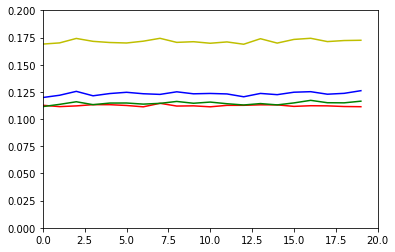

In [14]:
    plt.show()